# Importing all the conversations

This is a bit trickier as you need to do something with all the conversations you're loading up.

In [49]:
import datetime
import json
import os
import pickle
import random
import re
import textwrap
from pathlib import Path
from collections import OrderedDict

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.spatial import ConvexHull

import message_helpers as mh


ModuleNotFoundError: No module named 'message_helpers'

In [ ]:
plt.rcParams["figure.figsize"] = (20, 20)
plt.rcParams["font.sans-serif"] = ["Segoe UI Emoji"]


In [ ]:
pickle_name = "all_convo.pickle"
pickle_path = Path(pickle_name)


In [ ]:
def parse_obj(obj):
    for key in obj:
        if isinstance(obj[key], str):
            obj[key] = obj[key].encode("latin_1").decode("utf-8")
        elif isinstance(obj[key], list):
            obj[key] = list(
                map(
                    lambda x: x
                    if type(x) != str
                    else x.encode("latin_1").decode("utf-8"),
                    obj[key],
                )
            )
        pass
    return obj


def sumarise_convo(name, data, verbose=False):
    words = {}
    words[name] = data.content.str.cat(sep=" ")
    wordcount = len(words[name].split(" "))

    unique_words = set(words[name].split(" "))

    pool = " ".join([str(x) for x in data.content.to_list()]).lower()
    clean = re.sub(mh.PUNCTUATION_REGEX, " ", pool, flags=re.VERBOSE)
    # and replace it with a single space
    stopped = list(set([w for w in clean.split() if w not in mh.STOP_WORDS]))

    if verbose:
        print(
            f"{name} wrote {wordcount} words ({len(words[name])} characters)"
            f" and used {len(stopped)} different words."
        )
    return {
        "participant": name,
        "wordcount": wordcount,
        "unique_words": len(unique_words),
        "cleaned_unique": len(stopped),
    }


def get_message_length(message):
    if type(message) is str:
        return len(message)
    else:
        return len(str(message))


def replace_typographic_apostrophy(message):
    if type(message) is str:
        return message.replace("’", "'")
    else:
        return message


In [ ]:
def load_whole_inbox(rootdir, platform="Facebook"):
    conversations = []
    for d in os.listdir(rootdir):
        conversations.append(d)
    print(f"There are {len(conversations)} conversations to look at from {platform}.")
    # conversations

    convo_df_list = []

    if not pickle_path.is_file():
        for convo in os.listdir(rootdir):
            for f in os.listdir(os.path.join(rootdir, convo)):
                try:
                    message_list = []
                    path = os.path.join(os.path.join(rootdir, convo, f))
                    if Path(path).is_file():
                        with open(path, "r") as fb_data:
                            messages = json.load(fb_data, object_hook=parse_obj)
                            message_list.extend(messages["messages"])

                    if len(message_list) != 0:
                        df = pd.DataFrame(message_list)
                        df["source_convo"] = convo
                        df["datetime"] = df.timestamp_ms.apply(
                            lambda x: datetime.datetime.fromtimestamp(x / 1000.0)
                        )

                        if "content" in df.columns:
                            df["message_length"] = df.content.apply(get_message_length)
                            df.content = df.content.apply(
                                replace_typographic_apostrophy
                            )
                        else:
                            df["message_length"] = 0
                            df["content"] = np.nan

                        df["platform"] = platform

                        convo_df_list.append(df)

                except Exception as e:
                    print("exception", convo, e)
    return convo_df_list


fb_rootdir = "fb_data/messages/inbox"
fb_convo_df_list = load_whole_inbox(fb_rootdir, platform="Facebook")
ig_rootdir = "insta_data/messages/inbox"
ig_convo_df_list = load_whole_inbox(ig_rootdir, platform="Instagram")
convo_df_list = fb_convo_df_list + ig_convo_df_list
len(convo_df_list)


There are 191 conversations to look at from Facebook.
There are 141 conversations to look at from Instagram.


0

In [ ]:
if pickle_path.is_file():
    all_convo_df = pd.read_pickle(pickle_path)
else:
    all_convo_df = pd.concat(convo_df_list)
    pd.to_pickle(all_convo_df, pickle_path)
    all_convo_df.sample(10)

In [ ]:
def clean_and_stop(content, as_list=False):
    try:
        clean = re.sub(
            mh.PUNCTUATION_REGEX,
            " ",
            content,
            flags=re.VERBOSE,  # and replace it with a single space
        )
        stopped = [w.lower() for w in clean.split() if w.lower() not in mg.STOP_WORDS]
        # print(content, "=>", stopped)
        if as_list:
            return stopped
        else:
            return " ".join(stopped)
    except Exception as e:
        # print(content, e)
        return content


all_convo_df["clean_content"] = all_convo_df.content.apply(clean_and_stop)


In [ ]:
# words = {}
# for name, data in df.groupby("sender_name"):
#     words[name] = data.content.str.cat(sep=" ")
#     wordcount = len(words[name].split(" "))
#     # print(f"{name} wrote {wordcount} words ({len(words[name])} characters)")


In [ ]:
# for name, df in all_convo_df.groupby("platform"):
#     vc = df.sender_name.value_counts()
#     print(vc[vc>100].index)


In [ ]:
def fold_names(input_name):
    byron = "Byron Sullivan"
    charlie = "Charlie"
    karin = "Karin"
    ivana = "Ivana Kuzmanovska"
    julz = "Jülz Milthorpe"
    jess = "Jess Howard"
    jodie = "Jodie Hinton"
    tones = "Antonia Sheil"
    annisa = "Annisa Rivera Rizal"
    thesaurus = {
        "Byron Sullivan": byron,
        "Byron": byron,
        "Thearlaich Ogilive": charlie,
        "Charles OGILVIE": charlie,
        "Karin Frost": karin,
        "karin ke": karin,
        "Ivana Kuzmanovska": ivana,
        "ivana kuzmanovska": ivana,
        "Jülz": julz,
        "Jülz Milthorpe": julz,
        "jesshoward": jess,
        "Jess Howard": jess,
        "Jodie": jodie,
        "Tones": tones,
        "annisarivera": annisa,
    }
    new_name = thesaurus.get(input_name, input_name)
    # if new_name != input_name:
    #     print(f"renamed {input_name} to {new_name}")
    return new_name


all_convo_df["input_names"] = all_convo_df.sender_name
all_convo_df.sender_name = all_convo_df.sender_name.apply(fold_names)


In [ ]:
print(all_convo_df.shape)
all_convo_df.head(5)

(39415, 21)


,sender_name,timestamp_ms,content,type,is_unsent,source_convo,datetime,message_length,photos,sticker,...,call_duration,share,reactions,gifs,videos,audio_files,missed,users,clean_content,input_names
0,,1547017013329,넵,Generic,False,nimxf-gelg,2019-01-09 17:56:53.329,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,넵,
1,장수영,1547016964711,괜찮아요 다음부터 조심하세요~~,Generic,False,nimxf-gelg,2019-01-09 17:56:04.711,17,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,괜찮아요 다음부터 조심하세요~~,장수영
2,,1547016938868,찾았습니다... 감사합니다 정말..,Generic,False,nimxf-gelg,2019-01-09 17:55:38.868,19,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,찾았습니다... 감사합니다 정말..,
3,,1547016812510,아지금 3층으로가고있어요,Generic,False,nimxf-gelg,2019-01-09 17:53:32.510,13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,아지금 3층으로가고있어요,
4,장수영,1547016791852,찾으셨나요?,Generic,False,nimxf-gelg,2019-01-09 17:53:11.852,6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,찾으셨나요?,장수영


In [ ]:
conv_meta = []
for name, data in all_convo_df.groupby("sender_name"):
    conv_meta.append(sumarise_convo(name, data))
meta_df = pd.DataFrame(conv_meta)
meta_df["ratio"] = meta_df.apply(
    lambda row: row.wordcount / (row.cleaned_unique + 1), axis=1
)


NameError: name 'mh' is not defined

NameError: name 'meta_df' is not defined

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


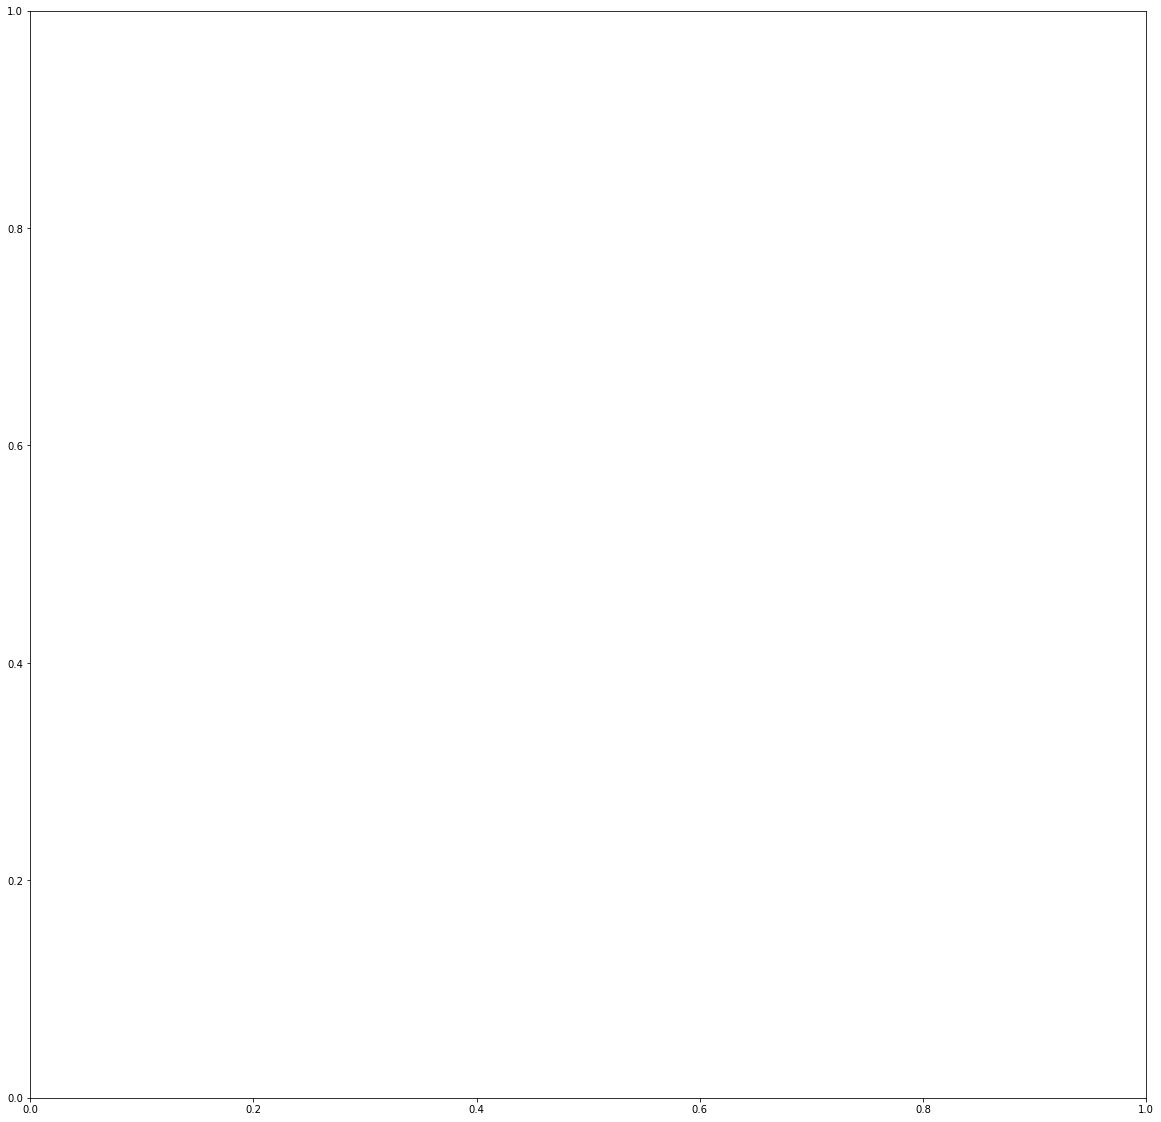

In [ ]:
fig = plt.figure()
ax = plt.gca()
# plt.scatter(meta_df.wordcount, meta_df.unique_words)
ax.scatter(meta_df.wordcount, meta_df.cleaned_unique)
plt.xlabel("Wordcount")
plt.ylabel("Number of unique words")
plt.xlim([0, 380000])
plt.ylim([0, 18000])

for i, row in meta_df.iterrows():
    if row.wordcount > 15000:
        # if row.wordcount > 15000:
        #     right = 60
        # else:
        #     right = 500
        plt.annotate(
            row.participant,
            (row.wordcount, row.cleaned_unique),
            size=10,
            xycoords="data",
            xytext=(
                random.randint(50, 130) * random.sample(range(-1, 1), k=1)[0],
                random.randint(50, 60) * random.sample(range(-1, 1), k=1)[0],
            ),
            textcoords="offset points",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"),
        )

# # define the true objective function
# def objective(x, a, b, c):
# 	return a * x + b * x**2 + c
# x=meta_df.wordcount
# y=meta_df.cleaned_unique
# # curve fit
# popt, _ = curve_fit(objective, x, y)
# # summarize the parameter values
# a, b, c = popt
# print('y = %.5f * x + %.5f * x^2 + %.5f' % (a, b, c))

# # define a sequence of inputs between the smallest and largest known inputs
# x_line = np.arange(min(x), max(x), 1)
# # calculate the output for the range
# y_line = objective(x_line, a, b, c)
# # create a line plot for the mapping function
# plt.plot(x_line, y_line, '--', color='red')


In [ ]:
meta_df[meta_df.wordcount > 5000].set_index(
    "participant"
).ratio.sort_values().plot.barh()
plt.title(
    "Ratio of wordcount to unique words count\n(only showing those with word counts over 5k)"
)


NameError: name 'meta_df' is not defined

<AxesSubplot:title={'center':'Number of messages sent (between 500 & 100000)'}>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50689 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44032 missing from curr

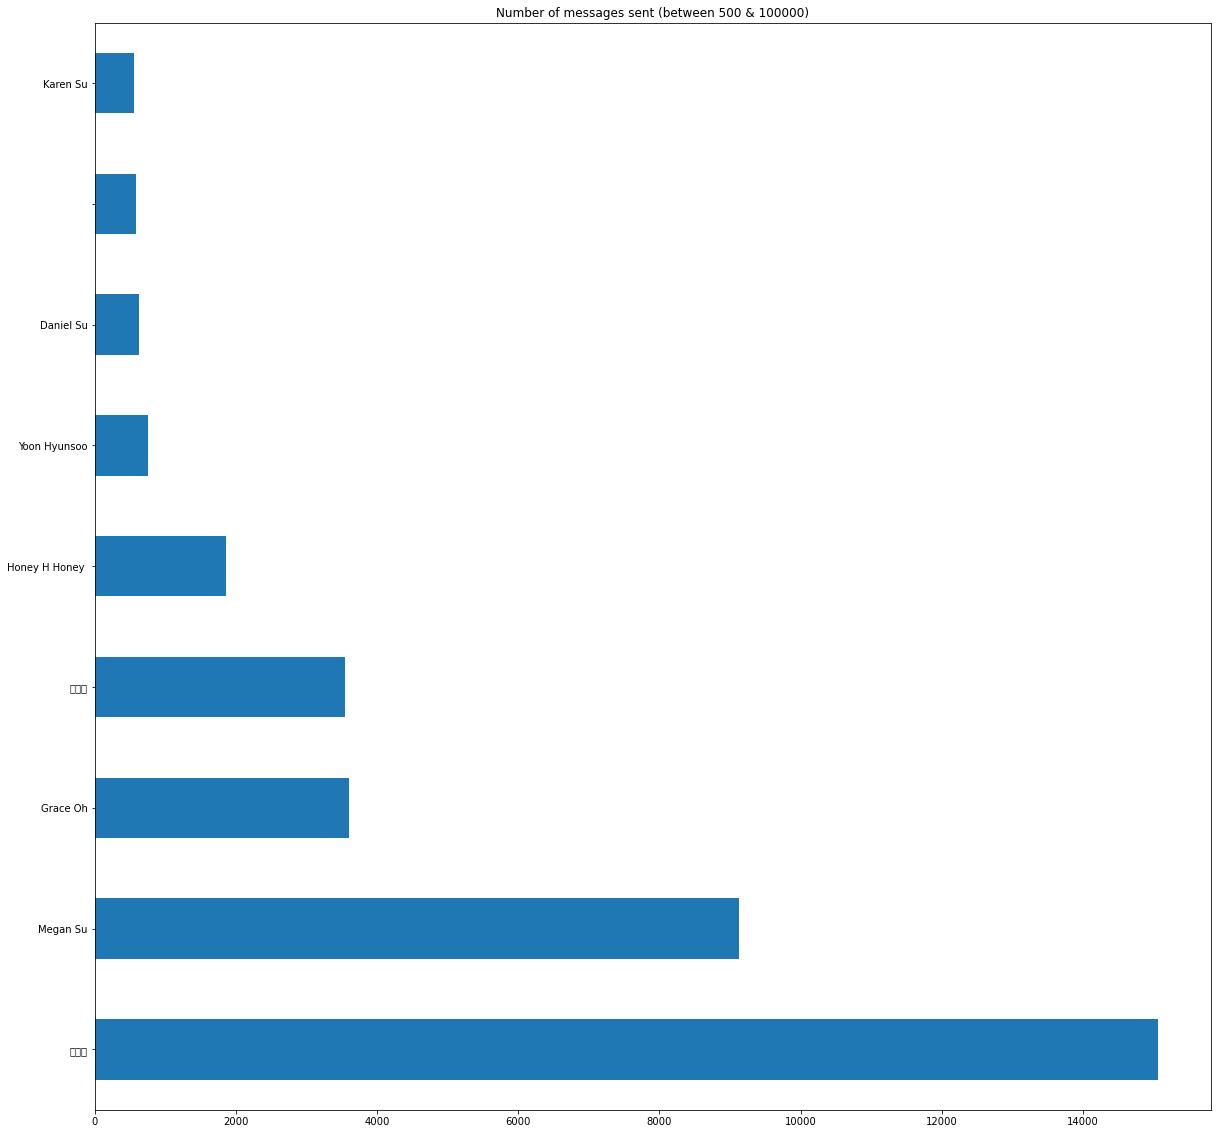

In [ ]:
vc = all_convo_df.sender_name.value_counts()
lb, ub = (500, 100000)
vc[(vc > lb) & (vc < ub)].plot.barh(
    title=f"Number of messages sent (between {lb} & {ub})"
)


In [ ]:
chatty_people = all_convo_df.sender_name.value_counts() > 1000
all_convo_df["chatty_people"] = [chatty_people[x] for x in all_convo_df.sender_name]
all_convo_df.sample(10)


,sender_name,timestamp_ms,content,type,is_unsent,source_convo,datetime,message_length,photos,sticker,...,share,reactions,gifs,videos,audio_files,missed,users,clean_content,input_names,chatty_people
5619,Megan Su,1438484986190,NaN,Generic,False,megansu_zepkvzqqpg,2015-08-02 13:09:46.190,3,[{'uri': 'messages/inbox/megansu_zepkvzqqpg/ph...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Megan Su,True
906,장수영,1494942552163,아니 ㅋㅋㅋㅋㅋㅋ,Generic,False,yoonhyunsoo_hm0zaf3adg,2017-05-16 23:49:12.163,9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,아니 ㅋㅋㅋㅋㅋㅋ,장수영,True
319,장수영,1545567988809,ㅋㅋㅋㅋ 엄........ 아돈노,Generic,False,graceoh_xe0pq10crg,2018-12-23 23:26:28.809,18,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ㅋㅋㅋㅋ 엄........ 아돈노,장수영,True
4912,장수영,1450733973181,Where ru?,Generic,False,megansu_zepkvzqqpg,2015-12-22 08:39:33.181,9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Where ru?,장수영,True
1529,Megan Su,1618627106652,Lol is mum there yet,Generic,False,megansu_zepkvzqqpg,2021-04-17 12:38:26.652,20,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lol is mum there yet,Megan Su,True
9817,장수영,1555564016539,Sad,Generic,False,megansu_zepkvzqqpg,2019-04-18 15:06:56.539,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sad,장수영,True
69,Dingqian Li,1616033140295,Presentation,Generic,False,dingqianli_ilb8fo3uva,2021-03-18 13:05:40.295,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Presentation,Dingqian Li,False
417,Megan Su,1623050260477,O was there another day?,Generic,False,megansu_zepkvzqqpg,2021-06-07 17:17:40.477,24,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O was there another day?,Megan Su,True
2048,Megan Su,1506680324026,Duuuuuuude,Generic,False,megansu_zepkvzqqpg,2017-09-29 20:18:44.026,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Duuuuuuude,Megan Su,True
2314,장수영,1498258961736,Some random students,Generic,False,megansu_zepkvzqqpg,2017-06-24 09:02:41.736,20,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Some random students,장수영,True


# Plotting time that might show sleep

This is a bit nasty, I don't really like it, but it seems to work. There _must_ be a better way.

Convert the time component of the datetime to just-date and just-time (but in seconds, as a number) and then plot that.

The y axis is nasty becasue it doesn't show 

In [ ]:
def time_to_seconds(dt):
    t = dt.time()
    seconds = (t.hour * 60 + t.minute) * 60 + t.second
    return seconds


all_convo_df["date"] = all_convo_df.datetime.apply(lambda x: x.date())
all_convo_df["time"] = all_convo_df.datetime.apply(lambda x: x.time())
all_convo_df["seconds"] = all_convo_df.datetime.apply(time_to_seconds)
all_convo_df.sample(5)


,sender_name,timestamp_ms,content,type,is_unsent,source_convo,datetime,message_length,photos,sticker,...,videos,audio_files,missed,users,clean_content,input_names,chatty_people,date,time,seconds
3762,장수영,1477568920060,NaN,Generic,False,megansu_zepkvzqqpg,2016-10-27 22:48:40.060,3,NaN,{'uri': 'messages/stickers_used/10540963_82325...,...,NaN,NaN,NaN,NaN,NaN,장수영,True,2016-10-27,22:48:40.060000,82120
4451,장수영,1431681519170,언니 나랑같은폰임,Generic,False,igayeong_ko9r4gr9tq,2015-05-15 19:18:39.170,9,NaN,NaN,...,NaN,NaN,NaN,NaN,언니 나랑같은폰임,장수영,True,2015-05-15,19:18:39.170000,69519
6662,Megan Su,1584958518782,WTF IS THISSSS?!?!,Generic,False,megansu_zepkvzqqpg,2020-03-23 21:15:18.782,18,NaN,NaN,...,NaN,NaN,NaN,NaN,WTF IS THISSSS?!?!,Megan Su,True,2020-03-23,21:15:18.782000,76518
7863,장수영,1575347360816,Apparently i need to dispute,Generic,False,megansu_zepkvzqqpg,2019-12-03 15:29:20.816,28,NaN,NaN,...,NaN,NaN,NaN,NaN,Apparently i need to dispute,장수영,True,2019-12-03,15:29:20.816000,55760
172,Yoon Hyunsoo,1496758496947,너 원래 12시쯤에 자지않았나?,Generic,False,yoonhyunsoo_hm0zaf3adg,2017-06-07 00:14:56.947,17,NaN,NaN,...,NaN,NaN,NaN,NaN,너 원래 12시쯤에 자지않았나?,Yoon Hyunsoo,False,2017-06-07,00:14:56.947000,896


KeyError: 'platform'

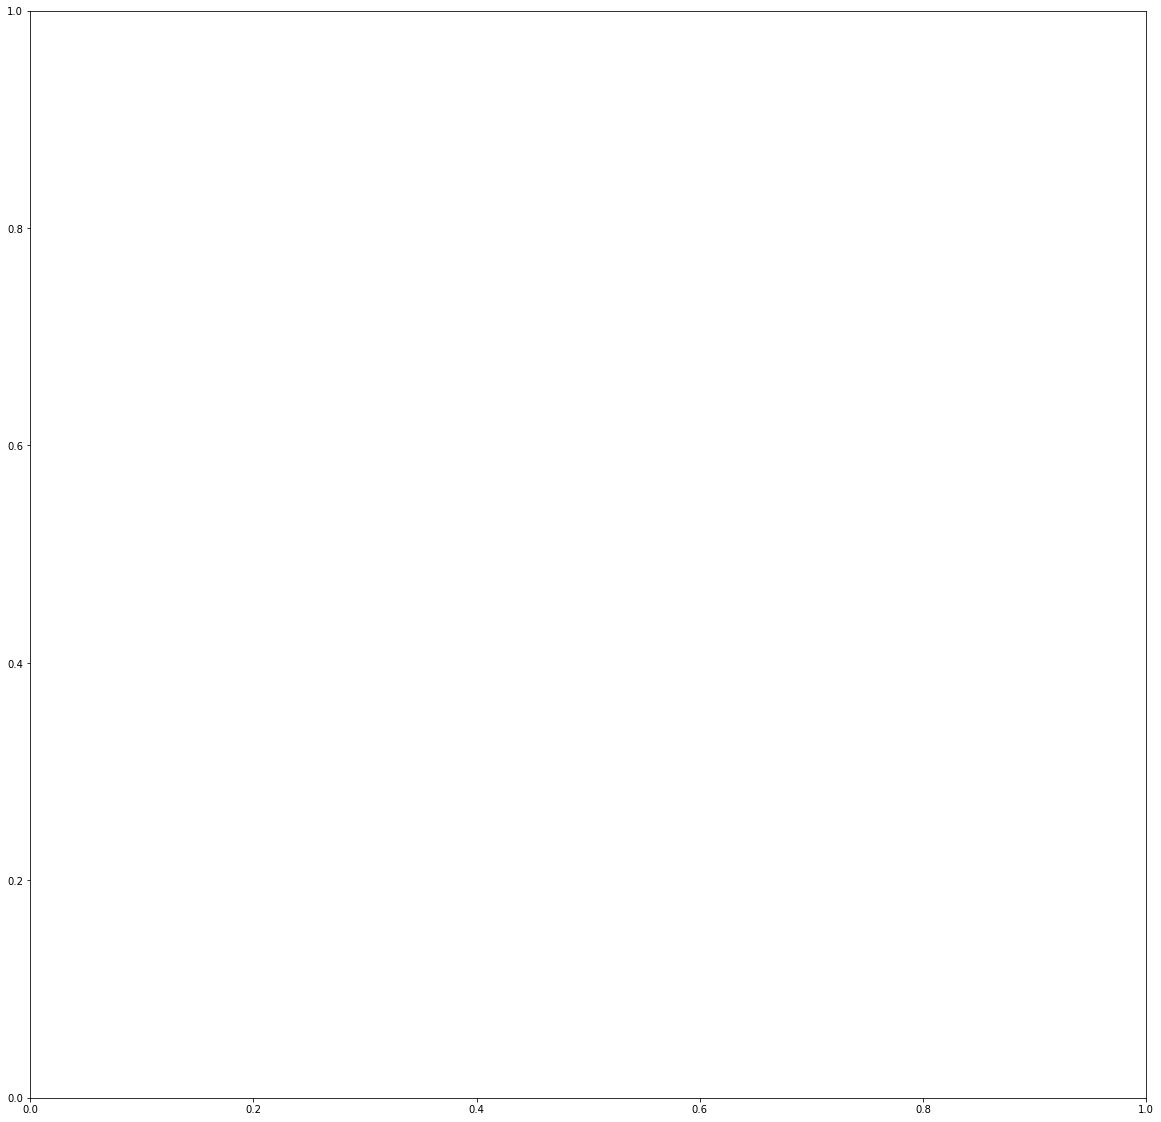

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
for name, df in all_convo_df.groupby("platform"):
    ax.scatter(df.date, df.seconds, s=20, alpha=0.04, label=name)
ax.yaxis_date()
fig.autofmt_xdate()
plt.title("all messages in and out")
plt.ylabel("seconds after midnight GMT")

plt.show()


So, this makes sense to me, but it's a bit gross. The y axis is all messed up, it should be showing time, not number of seconds. I'm also not sure if time goes forward up or down the page.

It'd be good to work out a way of identifying sleep periods. Maybe that's a period that starts after 10pm that's offline for more than 4 hours?

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
Font 'rm' does not have a glyph for '\uc774' [U+c774], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\uc7a5' [U+c7a5], substituting with a dummy symbol.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 50689 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: Runtim

[' (, 578)', 'Daniel Su (DS, 621)', 'Grace Oh (GO, 3597)', 'Honey H Honey  (HHH, 1865)', 'Karen Su (KS, 562)', 'Megan Su (MS, 9128)', 'Yoon Hyunsoo (YH, 747)', '이가영 (이, 3540)', '장수영 (장, 15060)']


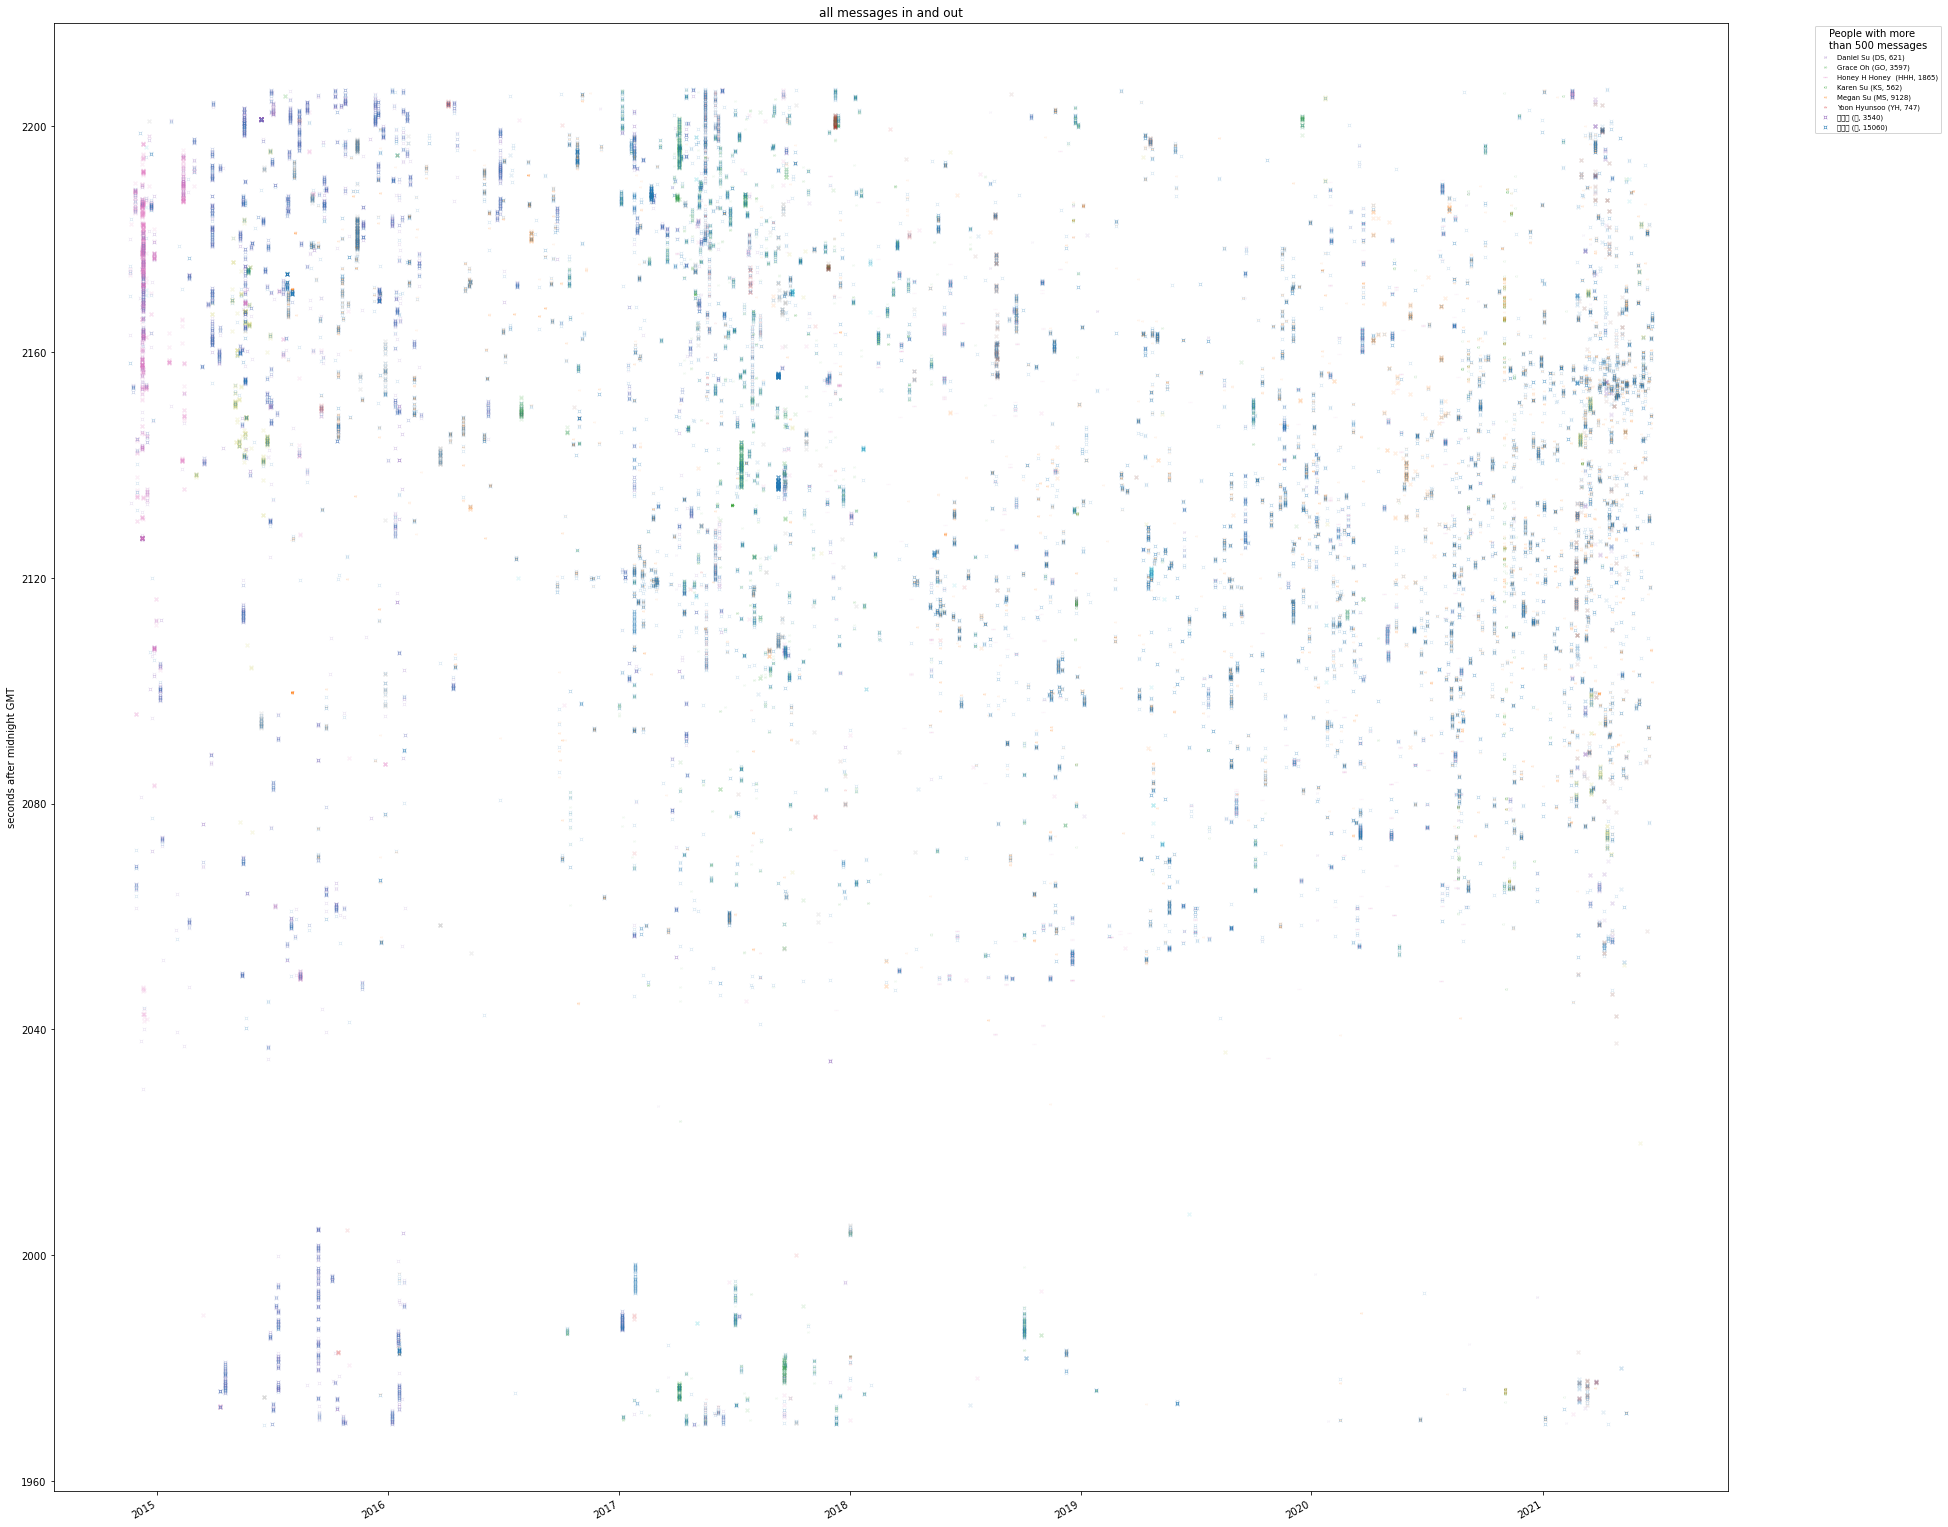

In [ ]:
plt.rcParams["figure.figsize"] = (30, 30)

cut = 500
labels = []
odd_df = None

fontP = FontProperties()
fontP.set_size("x-small")
all_initials = []

fig = plt.figure()
ax = fig.add_subplot(111)
for name, df in all_convo_df.groupby("sender_name"):
    if df.shape[0] > cut:
        initials = "".join([n[0] for n in name.split()]).upper()
        if initials in all_initials:
            print("uh oh, double up on", initials, name)
            initials = (
                "".join([n[0] for n in name.split()]).upper() + name.split()[-1][1]
            )
            print("replaced with", initials)
        else:
            all_initials.append(initials)

        label = f"{name} ({initials}, {df.shape[0]})"

        if name == "Ben Doherty":
            marker = ","
            ax.scatter(
                df.date,
                df.seconds,
                s=0.3,
                alpha=0.3,
                linewidth=0,
                label=label,
                marker=marker,
            )
        elif len(initials) > 0:
            marker = f"${initials}$"
            ax.scatter(
                df.date,
                df.seconds,
                s=10 if len(initials) == 2 else 15,
                alpha=0.2,
                linewidth=0,
                label=label,
                marker=marker,
            )
        else:
            # marker = "1"
            # print(name, "odd one", df.content.head(10))
            odd_df = df

        labels.append(label)
    else:
        ax.scatter(
            df.date,
            df.seconds,
            s=15,
            alpha=0.1,
            marker="x",
        )
ax.yaxis_date()
fig.autofmt_xdate()
plt.title("all messages in and out")
plt.ylabel("seconds after midnight GMT")
leg = plt.legend(
    title=f"People with more\nthan {cut} messages",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    prop=fontP,
)
for lh in leg.legendHandles:
    lh.set_alpha(1)

plt.savefig("all_messages.svg")
# plt.show()
print(labels)


/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50689 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anacon

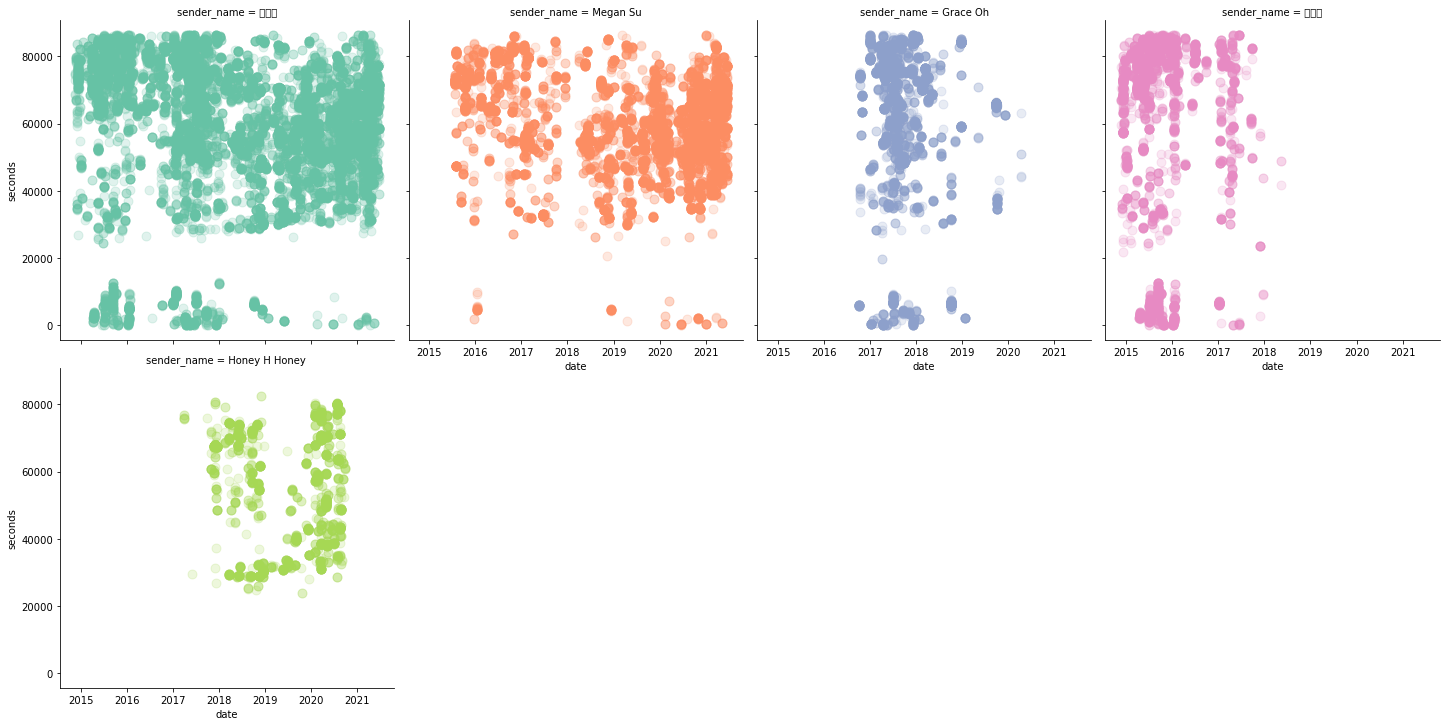

In [ ]:
plot = sns.lmplot(
    x="date",
    y="seconds",
    data=all_convo_df[all_convo_df["chatty_people"]],
    # data=all_convo_df,
    hue="sender_name",
    fit_reg=False,
    legend=True,
    palette="Set2",
    col="sender_name",
    col_wrap=4,
    scatter_kws=dict(s=80, alpha=0.2),
)


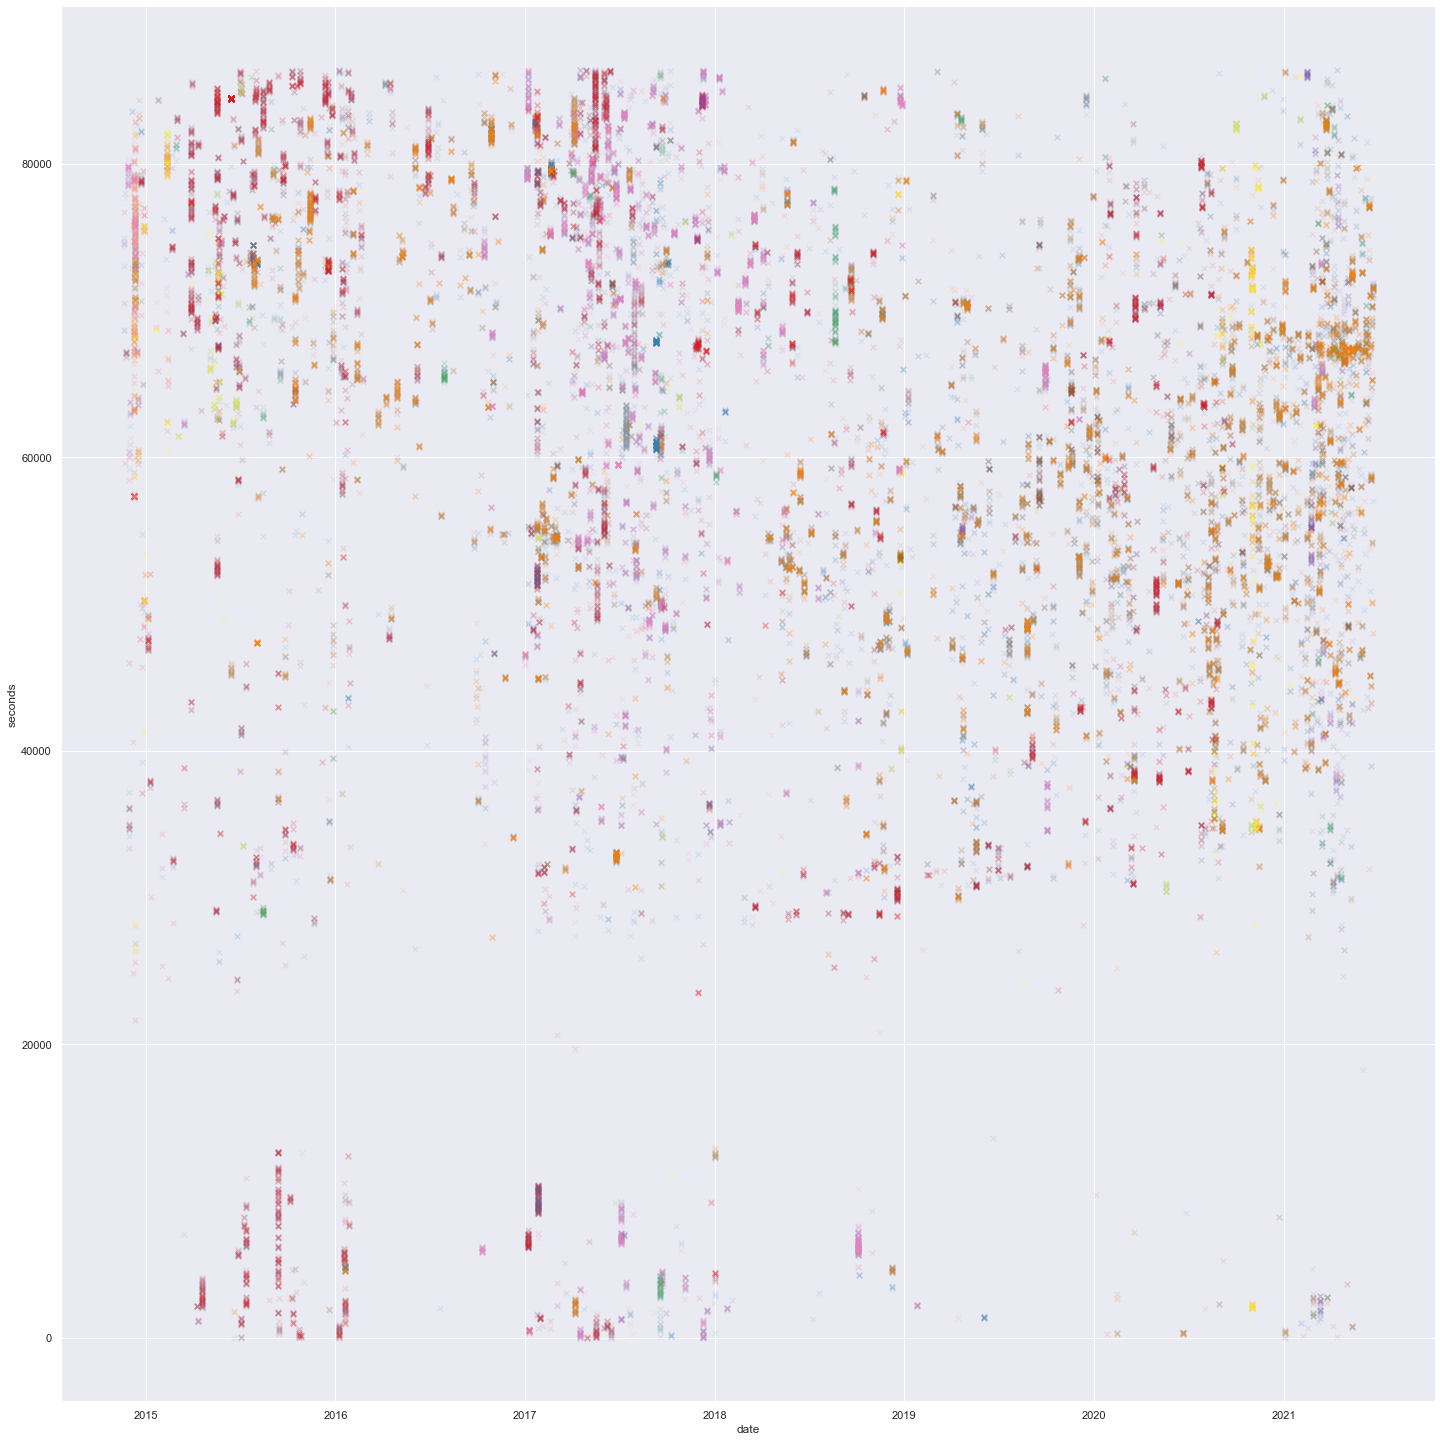

In [ ]:
sns.set(rc={"figure.figsize": (15, 15)})
plot = sns.lmplot(
    x="date",
    y="seconds",
    data=all_convo_df[all_convo_df.sender_name != "Ben Doherty"],
    hue="sender_name",
    markers="x",
    fit_reg=False,
    legend=False,
    palette="Set1",
    scatter_kws=dict(s=30, alpha=0.1),
    height=20,
    aspect=20 / 20,
)
# plt.xticks(rotation=45);
plt.savefig("all_incoming.svg")
plt.savefig("all_incoming.png")


In [ ]:
data = all_convo_df[all_convo_df.sender_name != "장수영"]
data = data[data.chatty_people]
print(data.shape)
data.sample(3)


(18130, 25)


,sender_name,timestamp_ms,content,type,is_unsent,source_convo,datetime,message_length,photos,sticker,...,videos,audio_files,missed,users,clean_content,input_names,chatty_people,date,time,seconds
4796,Megan Su,1454493184131,yes u r,Generic,False,megansu_zepkvzqqpg,2016-02-03 20:53:04.131,7,NaN,NaN,...,NaN,NaN,NaN,NaN,yes u r,Megan Su,True,2016-02-03,20:53:04.131000,75184
5516,Megan Su,1599211684781,Omg i need to peeeee,Generic,False,megansu_zepkvzqqpg,2020-09-04 19:28:04.781,20,NaN,NaN,...,NaN,NaN,NaN,NaN,Omg i need to peeeee,Megan Su,True,2020-09-04,19:28:04.781000,70084
88,Grace Oh,1487411883316,아니 아직은,Generic,False,ttolm_7qmkrekacg,2017-02-18 20:58:03.316,6,NaN,NaN,...,NaN,NaN,NaN,NaN,아니 아직은,Grace Oh,True,2017-02-18,20:58:03.316000,75483


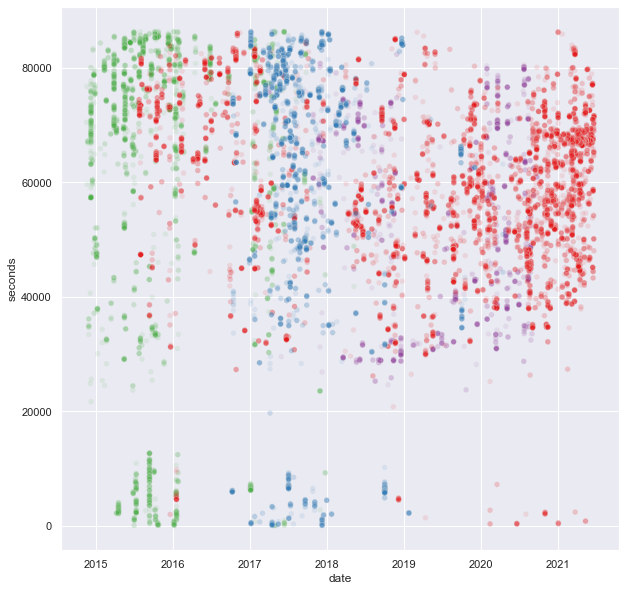

In [ ]:
sns.set(rc={"figure.figsize": (10, 10)})
fig, ax = plt.subplots()
g = sns.scatterplot(
    x="date",
    y="seconds",
    data=data,
    hue="sender_name",
    legend=False,
    palette="Set1",
    s=30,
    alpha=0.1,
    ax=ax,
)
# g.legend(bbox_to_anchor=(1.5, 1))


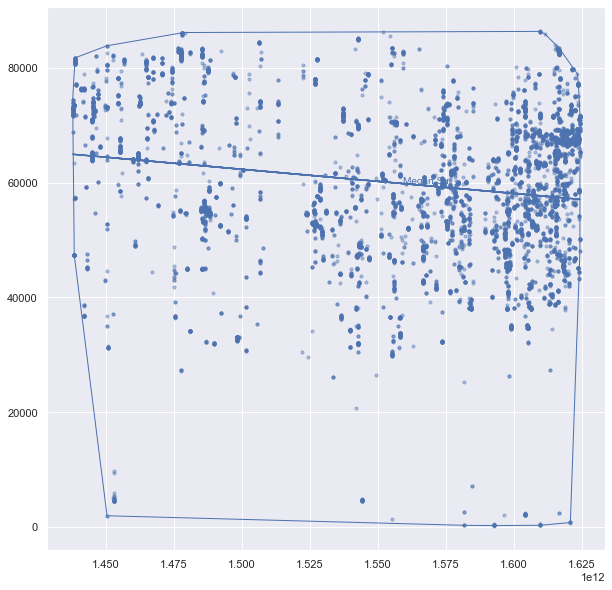

In [ ]:
def encircle(x, y, ax=None, **kw):
    if not ax:
        ax = plt.gca()
    p = np.c_[x, y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices, :], **kw)
    ax.add_patch(poly)


fig, ax = plt.subplots()
for x, d in data.groupby("sender_name"):
    if d.shape[0] > 4000:
        m, b = np.polyfit(d.timestamp_ms, d.seconds, 1)
        plt.plot(d.timestamp_ms, m * d.timestamp_ms + b)
        col = plt.gca().lines[-1].get_color()
        sc = ax.scatter(d.timestamp_ms, d.seconds, s=10, alpha=0.4, label=x, color=col)
        encircle(d.timestamp_ms, d.seconds, ax=ax, ec=col, fc="none")
        plt.annotate(x, (d.timestamp_ms.mean(), d.seconds.mean()), size=10, color=col)

plt.show()


ValueError: zero-size array to reduction operation fmin which has no identity

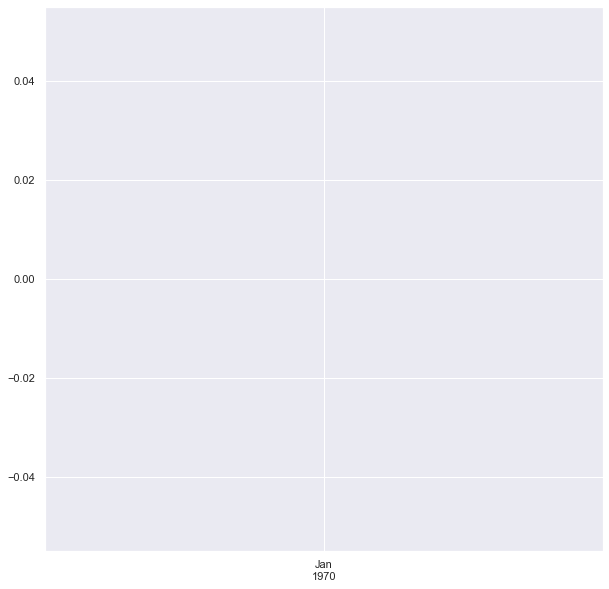

In [ ]:
bd_out_df = all_convo_df[all_convo_df.sender_name == "Ben Doherty"]
bd_out_df.set_index("datetime").groupby(pd.Grouper(freq="M")).count().sender_name.plot()
plt.title("Messages sent per Month")


/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50689 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/

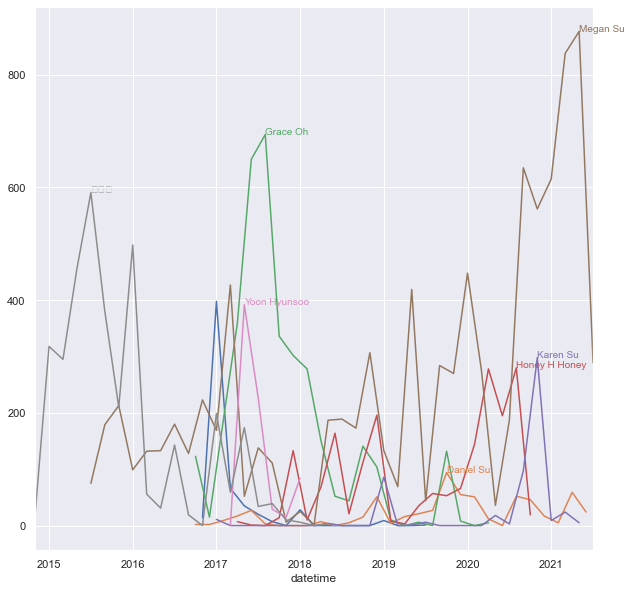

In [ ]:
fig, ax = plt.subplots()
for x, d in all_convo_df.groupby("sender_name"):
    if d.shape[0] > 500 and x != "장수영":
        per_period = (
            d.set_index("datetime").groupby(pd.Grouper(freq="2m")).count().sender_name
        )
        per_period.plot()
        col = plt.gca().lines[-1].get_color()
        plt.annotate(x, (per_period.idxmax(), per_period.max()), size=10, color=col)


In [ ]:
SOO_WORDS = [
    "poop",
    "home",
    "doughnut",
]


def is_soo(content):
    try:
        if any(x.lower() in content for x in SOO_WORDS):
            return "soo"
    except:
        pass
    return "not"


In [ ]:
all_convo_df["장수영"] = all_convo_df.content.apply(is_장수영)

fig = plt.figure()
ax = fig.add_subplot(111)
for name, data in all_convo_df.groupby("장수영"):
    if name == "장수영":
        ax.scatter(data.date, data.seconds, s=30, alpha=0.5, c="red", marker="x")
    else:
        ax.scatter(data.date, data.seconds, s=10, alpha=0.1, c="blue", marker=".")

# ax.yaxis_date()
seconds_in_a_day = 24 * 60 * 60
ax.yaxis.set_major_locator(plt.MaxNLocator(30))
# plt.yticks(plt.yticks()[0], [datetime.timedelta(seconds=t)  for t in plt.yticks()[0]])
plt.ylim([0, seconds_in_a_day])

ax.xaxis.set_major_locator(plt.MaxNLocator(30))
fig.autofmt_xdate()
# plt.xlim(['2020-07-18', '2021-07-21'])

plt.suptitle("When do we talk soo?")
plt.title(f"Occurance of {', '.join(SOO_WORDS)}")

plt.show()


NameError: name 'is_장수영' is not defined

In [ ]:
top = 50

pool = " ".join(all_convo_df[all_convo_df.soo == "장수영"].content.to_list())
clean = re.sub(
    mh.PUNCTUATION_REGEX, " ", pool, flags=re.VERBOSE  # and replace it with a single space
)
stopped = [w.lower() for w in clean.split() if w.lower() not in mh.STOP_WORDS]
vc = pd.Series(stopped).value_counts()
vc[:top].plot.barh()
plt.title(f'Top {top} most common words in "soo" messages')


AttributeError: 'DataFrame' object has no attribute 'soo'

In [ ]:
pool = " ".join([str(x) for x in all_convo_df.content])
clean = re.sub(
    mh.PUNCTUATION_REGEX, " ", pool, flags=re.VERBOSE  # and replace it with a single space
)
stopped = [w.lower() for w in clean.split() if w.lower() not in mh.STOP_WORDS]
vc = pd.Series(stopped).value_counts()
vc[:top].plot.barh()
plt.title(f"Top {top} most common words in all messages")


In [ ]:
ratios = {}
for name, df in all_convo_df.groupby("sender_name"):
    if df.shape[0] > 1000:
        vc = df.soo.value_counts()
        ratios[name] = (vc.get("soo", 1)) / vc["not"]
highly_soo = pd.Series(ratios).sort_values()
highly_soo.plot.barh()


In [ ]:
# print(highly_soo.index)
highly_soo_df = all_convo_df[
    [x in list(highly_soo.index) for x in all_convo_df.sender_name]
]


In [ ]:
occurances = []
for name, df in highly_soo_df.groupby("sender_name"):
    d = {"name": name}
    pool = " ".join([str(x) for x in df.content])
    for w in SOO_WORDS:
        oc = pool.count(w)
        d[w] = oc
    occurances.append(d)


In [ ]:
sdf = pd.DataFrame(occurances)
sdf = sdf.set_index("name")
sdf.head()


In [ ]:
sdf_normed = sdf.div(sdf.sum(axis=1), axis=0)
sdf_normed.plot.barh(edgecolor="none")
plt.title("Occurances of these words (normalised per person)")


In [ ]:
sdf[sdf.index != "Ben Doherty"].plot.barh(edgecolor="none")
plt.title("Occurances of these words (not normalised per person)")


In [ ]:
p = [
    "Ben Doherty",
    "Ivana Kuzmanovska",
    "More People"
]
# This will fail because there isnt' a person in the dataset called "More People"
sdf_normed.loc[p].plot.barh(edgecolor="none", width=0.7,)
plt.title(f"Occurances of these words in messages from \n{p} (normalised)")


In [ ]:
sdf.sum(axis=0).plot.barh()
plt.title("General occurance of these words")
